In [464]:
import numpy as np
from numpy import pi as π
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import firedrake
from firedrake import Constant, assemble,inner, sqrt, tr, grad, div, as_vector, exp,sym, as_vector, dx, ds, Mesh, Function, conditional
import irksome
from irksome import Dt
from scipy.signal import detrend
import copy
import matplotlib.pyplot as plt
import matplotlib

# Initial mesh

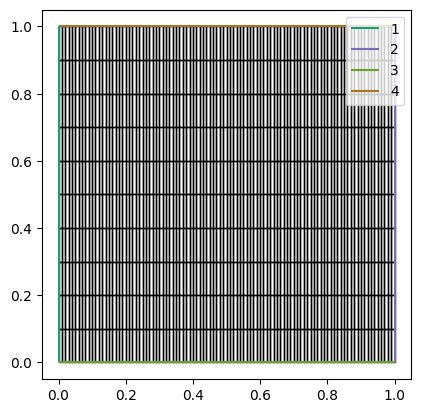

In [465]:
#Creating the initial mesh dimensions

nx, nz = 100, 10
initial_mesh = firedrake.UnitSquareMesh(nx, nz, quadrilateral=True)

fig, ax = plt.subplots()
ax.set_aspect("equal")
firedrake.triplot(initial_mesh, axes=ax)
ax.legend();

# Change the mesh coordinates to what domain we want

### And another example mesh

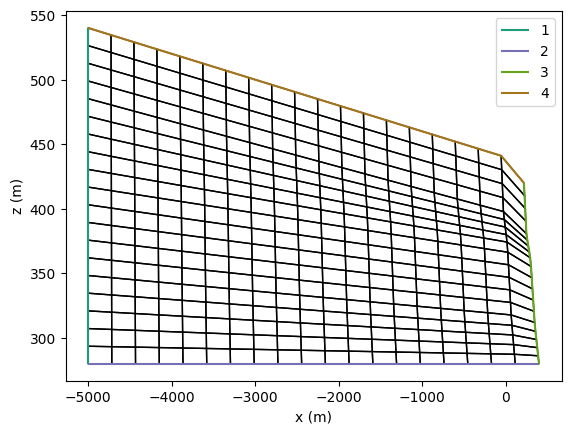

In [466]:
x, z = firedrake.SpatialCoordinate(initial_mesh)

# Input the mesh dimensions here, not sure how to do this automatically
depth = 160
height_max = 440
height_min = 280
length = 250

slope = (height_max - height_min) / length

mesh = Mesh('MICI_domain.msh')

x, z = firedrake.SpatialCoordinate(mesh)

# # Access the coordinates
# coordinates = mesh.coordinates

# # Get the min x (left) and max y (top) for translation
# x_min = min(coordinates.dat.data[:, 0])
# z_max = max(coordinates.dat.data[:, 1])

# # Create a new Function for the translated coordinates
# new_coordinates = Function(coordinates.function_space())

# # Translate the coordinates: move (x_min, y_max) to (0, 0)
# new_coordinates.interpolate(as_vector([x - x_min,-1* (z_max - z)]))

# # Assign the new coordinates back to the mesh
# mesh.coordinates.assign(new_coordinates)


surface_id = [4]
left_id = [1]
bed_id = [2]
right_id = [3]


fig, ax = plt.subplots()
ax.set_aspect("auto")
ax.set_xlabel("x (m)")
ax.set_ylabel("z (m)")
firedrake.triplot(mesh, axes=ax)
ax.set_aspect("auto")
ax.legend();

# Modeling the initial conditions

In [467]:
# Constants
spy = 365.25 * 24 * 60 * 60
ρ = Constant(917.0)    # kg / m^3
c = Constant(2180)     # J / kg C
k = Constant(2.22)  # W / m C
α = (k/(ρ*c)) # diffusivity
n = 3
A = 3.5e-25 
n = 3
R = 8.31446261815324
act_vol = -1.74e-5
Q = 6e4 # activatyion energy J/mol
dTdz = 2e-2 #C per 100m
geo_flux = Constant(46e-3) #W/m^2

λ = Constant(10.0)    # m
grav = Constant(-9.81) #m/s^2

vel_mpy = Constant(0.50) #m/yr
vel = vel_mpy / spy

In [468]:
# Surface condition


T_mean = -31 #average temp (C)
T_surface = Constant(T_mean) #

In [469]:

# element = firedrake.FiniteElement("CG", "quadrilateral", 1)
# V = firedrake.FunctionSpace(mesh, element)

# T = firedrake.Function(V)
# ϕ = firedrake.TestFunction(V)


# geothermal_flux = -geo_flux*ϕ  * ds((bed_id[0]))

# # F = k * inner(grad(T), grad(ϕ)) * dx + geothermal_flux
# F = k * inner(grad(T), grad(ϕ)) * dx

# # surf_bc = firedrake.DirichletBC(V, T_surface, surf_ids)
# surf_bc = firedrake.DirichletBC(V, 0, surface_id) #slope / (1/100) term is the dry adiabat following the slope
# right_bc = firedrake.DirichletBC(V, 0, right_id) #slope / (1/100) term is the dry adiabat following the slope

# bcs = [surf_bc, right_bc]

# firedrake.solve(F == 0, T, bcs)

In [470]:
element = firedrake.FiniteElement("CG", "quadrilateral", 1)
V = firedrake.FunctionSpace(mesh, element)

pressure_space = firedrake.FunctionSpace(mesh, "CG", 1)
velocity_space = firedrake.VectorFunctionSpace(mesh, "CG", 2)
# pressure_func = Function(V, name="Pressure")
# pressure_func.interpolate(ρ*grav*h)


Y = velocity_space * pressure_space

y = firedrake.Function(Y)
u, p = firedrake.split(y)

T = firedrake.Function(V)
ϕ = firedrake.TestFunction(V)


F = k * inner(grad(T), grad(ϕ)) * dx 


surf_bc = firedrake.DirichletBC(V, 0, surface_id)
right_bc = firedrake.DirichletBC(V, 0, right_id)

bcs = [surf_bc, right_bc]

firedrake.solve(F == 0, T, bcs)

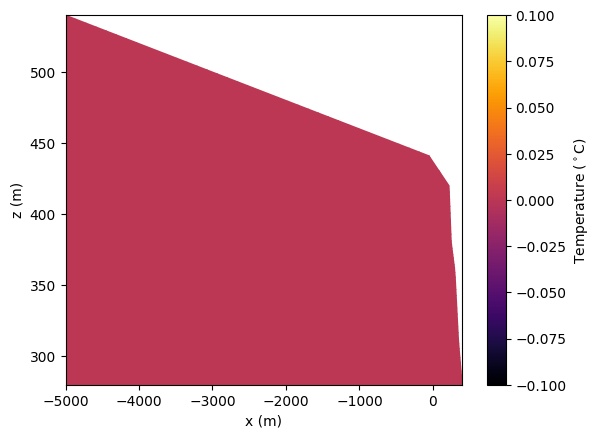

In [471]:
fig, ax = plt.subplots()
ax.set_aspect("auto")
ax.set_xlabel("x (m)")
ax.set_ylabel("z (m)")
colors = firedrake.tripcolor(T, cmap="inferno", axes=ax)
fig.colorbar(colors, label="Temperature (${}^\circ$C)")
levels = np.linspace(-30, 0, 8)
firedrake.tricontour(T, levels=levels, colors="grey", axes=ax)
# ax.set_xlim([9000,10000]);

# Variational form

$$\int_\Omega \rho c (T-T_n) \cdot \phi + \delta t \cdot \frac{k}{\rho c} \nabla T \cdot \nabla \phi - \rho c uT \cdot \nabla \phi- \rho cwT \cdot \nabla \phi + \frac{2}{\rho c} \dot{\epsilon}_{xz}\tau_{xz}\cdot\phi \: \mathrm{d}x + \int_{\Gamma} \frac{k}{\rho c}\nabla T * n\phi \: \mathrm{d}\gamma$$

# Building the model

In [472]:
# element = firedrake.FiniteElement("CG", "quadrilateral", 1)
# V = firedrake.FunctionSpace(mesh, element)

# T = firedrake.Function(V)
# ϕ = firedrake.TestFunction(V)


In [473]:
pressure_space = firedrake.FunctionSpace(mesh, "CG", 1)
velocity_space = firedrake.VectorFunctionSpace(mesh, "CG", 2)
Y = velocity_space * pressure_space

y = firedrake.Function(Y)
u, p = firedrake.split(y)


μ = Constant(5e16) #Ice
# μ = Constant(1e14) #Test
def ε(u):
    return sym(grad(u))

v, q = firedrake.TestFunctions(y.function_space())

τ = 2 * μ * ε(u)
g = as_vector((0, grav))
f =  ρ * g

F_momentum = (inner(τ, ε(v)) - q * div(u) - p * div(v) - inner(f, v)) * dx


In [474]:
# bc_b = firedrake.DirichletBC(Y.sub(0), as_vector((0, 0)), [3]) 
# bc_l = firedrake.DirichletBC(Y.sub(0), as_vector((vel, 0)), [1]) 
# bc=[bc_b,bc_l]

In [475]:
coordinates = mesh.coordinates.dat.data  
left_boundary = []
for i in coordinates:
    if i[0] == 0:
        left_boundary.append(i)
        
H = np.array(left_boundary)[:,1][0] - np.array(left_boundary)[:,1][-1]

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [476]:
# accum = Constant(0.05 / spy)


# velocity_profile_r = (0.05/spy) * (1-((z/500))**(n+1)) #What is this velocity?
# velocity_profile_l = (10/spy) * (1-((z/250))**(n+1)) #What is this velocity?
velocity_profile_l = 60/spy #What is this velocity?
# velocity_profile_z = - accum * ((1+(z/depth))**(n+1))
# velocity_profile_surf = - accum * (1-(x/length/2))

bed_velocity = 12 / spy

vel_left_profile = bed_velocity + ((2 * 24e-25) / (n+1))*(100e3**n)*H*(1-((-1*z/H))**(n+1))

bc_l = firedrake.DirichletBC(Y.sub(0), as_vector((0.0001/spy, 0)), left_id) 
bc_b = firedrake.DirichletBC(Y.sub(0), as_vector((0.0001/spy, 0)), bed_id) 


# bc_l = firedrake.DirichletBC(Y.sub(0), as_vector((60/spy, 0)), left_id) 
# bc_b = firedrake.DirichletBC(Y.sub(0), as_vector((12/spy, 0)), bed_id) 
# bc_r = firedrake.DirichletBC(Y.sub(0), as_vector((velocity_profile_r, 0)), right_id) 
# #bc_r = firedrake.DirichletBC(Y.sub(0), as_vector((0, 0)), right_id) 
# bc_s = firedrake.DirichletBC(Y.sub(0), as_vector((0, velocity_profile_surf)), [3]) # Not working

# bc_l = firedrake.DirichletBC(Y.sub(0), as_vector((velocity_profile, 0)), [1]) 
# bc=[bc_l, bc_b, bc_r]

bc=[bc_l,bc_b]

In [477]:
basis = firedrake.VectorSpaceBasis(constant=True, comm=firedrake.COMM_WORLD)
nullspace = firedrake.MixedVectorSpaceBasis(Y, [Y.sub(0), basis])

In [478]:
stokes_problem = firedrake.NonlinearVariationalProblem(F_momentum, y, bc)
# stokes_problem = firedrake.NonlinearVariationalProblem(F_momentum, y, )
parameters = {
    "nullspace": nullspace,
    "solver_parameters": {
        "ksp_type": "preonly",
        "pc_type": "lu",
        "pc_factor_mat_solver_type": "mumps",
    },
}
stokes_solver = firedrake.NonlinearVariationalSolver(stokes_problem, **parameters)

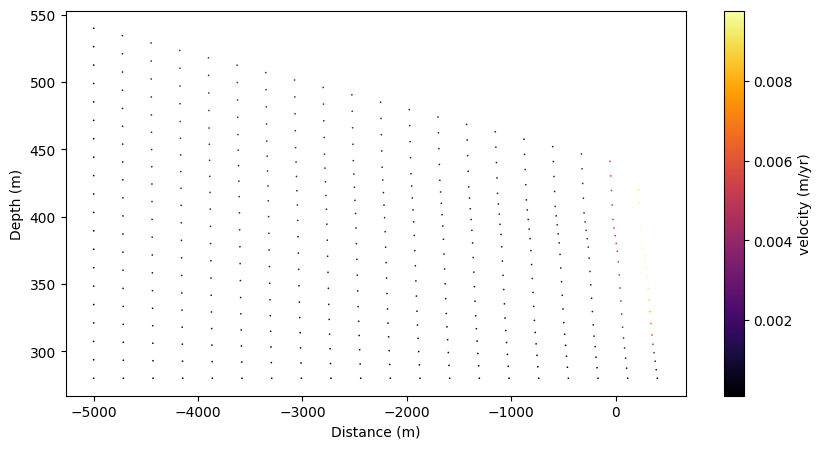

In [479]:
stokes_solver.solve()
fig, axes = plt.subplots(figsize = [10,5])
vel_field_plot = firedrake.quiver(y.sub(0)*spy, axes=axes, cmap="inferno", scale=.5, scale_units="xy")
fig.colorbar(vel_field_plot, label='velocity (m/yr)')
axes.set_ylabel('Depth (m)')
axes.set_xlabel('Distance (m)')
# axes.set_xlim([5000,10000])
# axes.set_ylim([-1200,-800])
plt.show()
# fig.savefig('Test_model_flowfield.png')

In [480]:
stokes_solver.solve()

# Extract the vector field components and coordinates
x_ex, y_ex = mesh.coordinates.dat.data.T
# Interpolate the vector field at mesh vertices
vx = np.array([y.sub(0).at([x_ex[i], y_ex[i]])[0] for i in range(len(x_ex))])
vy = np.array([y.sub(0).at([x_ex[i], y_ex[i]])[1] for i in range(len(y_ex))])

# Compute magnitudes and normalize vectors to have unit length
magnitudes = np.sqrt(vx**2 + vy**2)
vx_normalized = vx / magnitudes
vy_normalized = vy / magnitudes

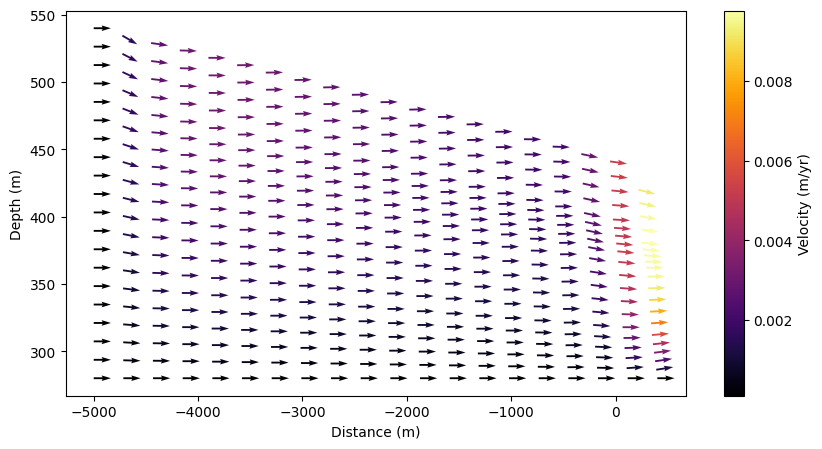

In [481]:
fig, axes = plt.subplots(figsize = [10,5])
vel_plot = plt.quiver(x_ex, y_ex, vx_normalized, vy_normalized, magnitudes*spy,cmap="inferno") # Adjust 'scale' as needed for visibility
plt.colorbar(vel_plot, label="Velocity (m/yr)")
axes.set_ylabel('Depth (m)')
axes.set_xlabel('Distance (m)')
fig.savefig('MICI_0boundaries.png')

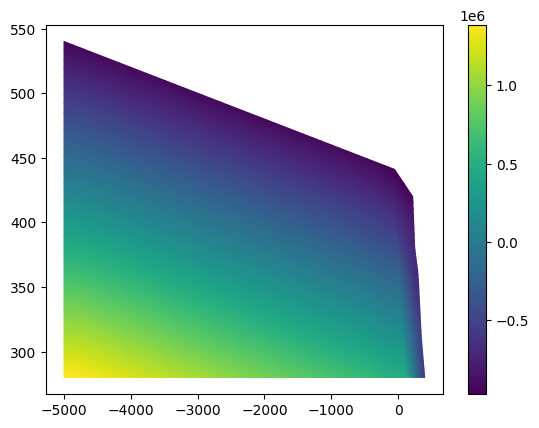

In [482]:
u, p = firedrake.split(y)
pressure_colors = Function(V).project(p)

fig,ax=plt.subplots()
im = firedrake.tripcolor(pressure_colors,axes=ax)
plt.colorbar(im)

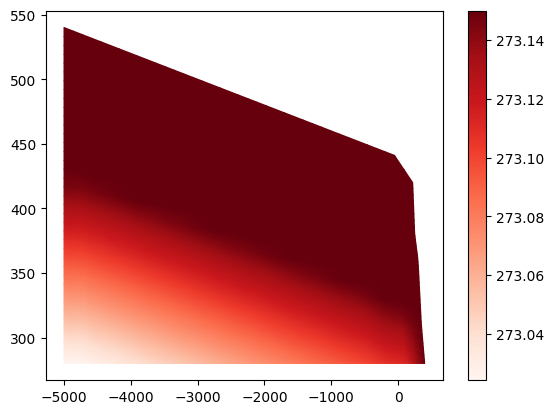

In [483]:
T_depress = 273.16 - 9.8e-8 *  p

T_depress_colors = Function(V).project(T_depress)

T_func = Function(V)
T_func.interpolate(conditional(T_depress_colors > 273.15, 273.15, T_depress_colors))
fig,ax=plt.subplots()
im = firedrake.tripcolor(T_func,axes=ax,cmap = 'Reds')
plt.colorbar(im)

3.539092713512977e-08


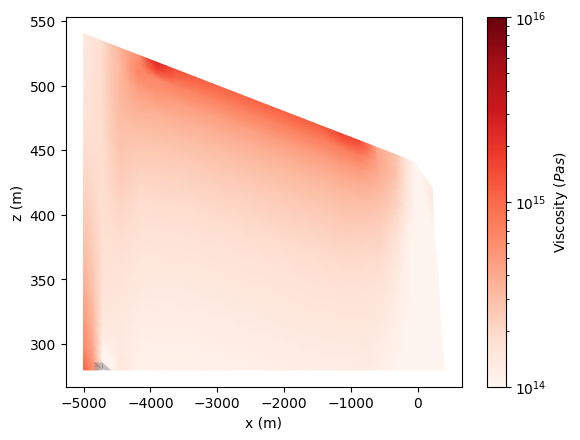

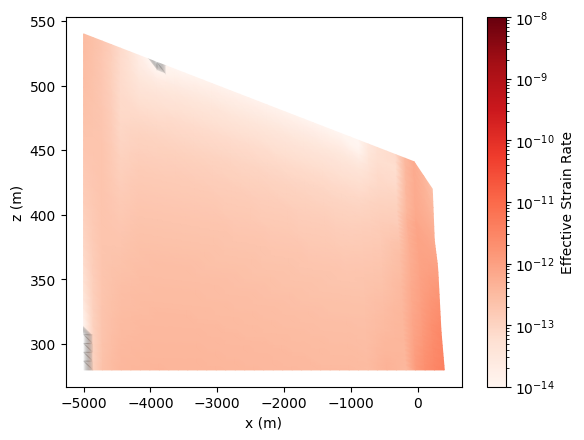

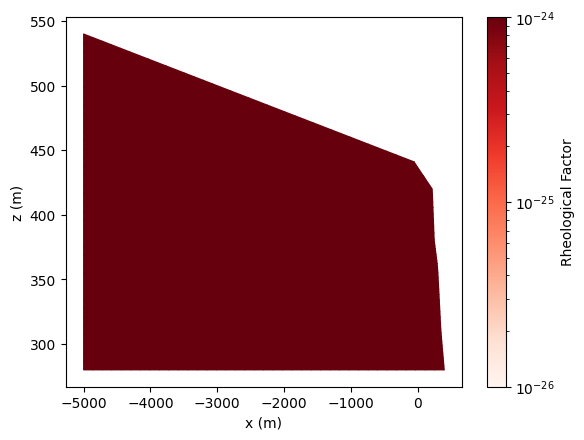

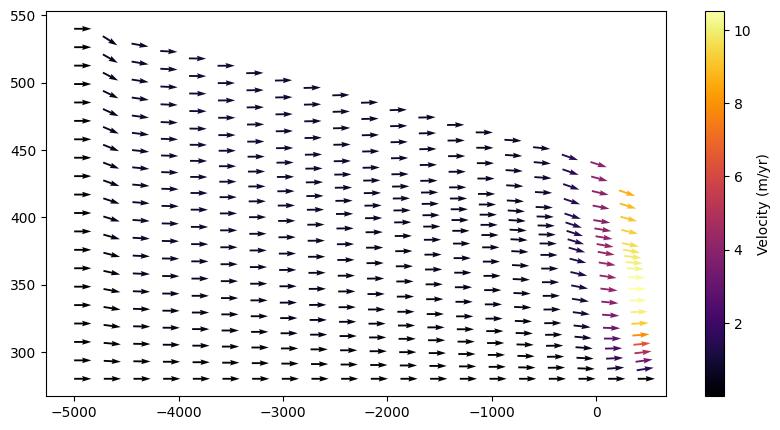

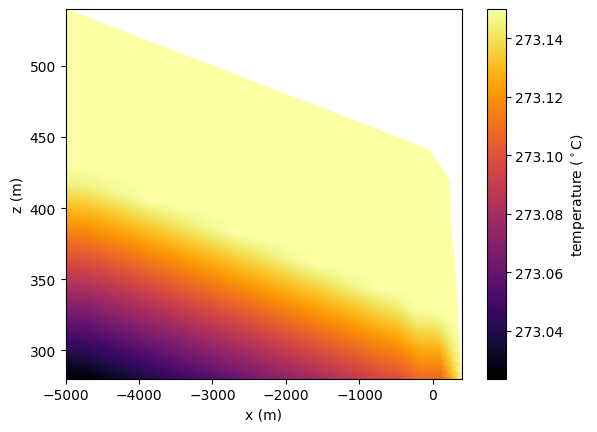

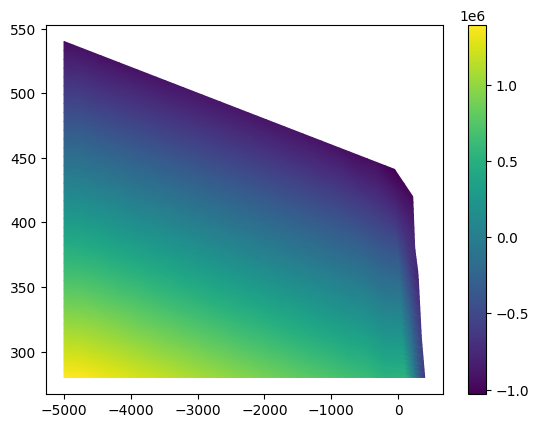

In [484]:
velocity_field = y.sub(0).dat.data
temp_field = T_func

for i in range(100):
    prev_temp_field = copy.deepcopy(temp_field)
    prev_velocity = copy.deepcopy(velocity_field)
    ϵ_ = sym(grad(u))
    
    ϵ_effective = sqrt((inner(ϵ_, ϵ_)+tr(ϵ_)**2)*0.5)
    
    # A_new = A*exp(-((Q + (p*act_vol))/((T+273.15)*R)))

    A_new = A*exp(-(Q/R*( 1/(prev_temp_field+273.15) - 1/263))) #Does not account for melting point depression
    μ_new =  0.5*(A_new**(-1/n))*(ϵ_effective**((1/n)-1))
    
    μ_new_field = Function(V).project(μ_new)
    ϵ_effective_field = Function(V).project(ϵ_effective)
    A_new_field = Function(V).project(A_new)

    def ε(u):
        return sym(grad(u))
    
    ### Build the stokes flow model ###
    
    pressure_space = firedrake.FunctionSpace(mesh, "CG", 1)
    velocity_space = firedrake.VectorFunctionSpace(mesh, "CG", 2)
    Y = velocity_space * pressure_space
    
    y = firedrake.Function(Y)
    u, p = firedrake.split(y)
    v, q = firedrake.TestFunctions(y.function_space())
    
    τ = 2* μ_new * ε(u)#  2 * μ_new_field *  ϵ_
    g = as_vector((0, grav))
    f =  ρ * g
    
    F_momentum = (inner(τ, ε(v)) - q * div(u) - p * div(v) - inner(f, v)) * dx

    basis = firedrake.VectorSpaceBasis(constant=True, comm=firedrake.COMM_WORLD)
    nullspace = firedrake.MixedVectorSpaceBasis(Y, [Y.sub(0), basis])

    stokes_problem = firedrake.NonlinearVariationalProblem(F_momentum, y, bc)
    parameters = {
        "nullspace": nullspace,
        "solver_parameters": {
            "ksp_type": "preonly",
            "pc_type": "lu",
            "pc_factor_mat_solver_type": "mumps",
        },
    }
    stokes_solver = firedrake.NonlinearVariationalSolver(stokes_problem, **parameters)

    stokes_solver.solve()

    
    ### Get the new velocity field solved for ###
    velocity_field = y.sub(0).dat.data


    
    # ### Build the temperature model ###
    
    # F_diffusion = k*inner(grad(T), grad(ϕ)) * dx
    # F_advection = - ρ * c * T * inner(u, grad(ϕ)) * dx
    # # geothermal_flux = -geo_flux*ϕ  * ds((bed_id[0]))
 
    # F_0 = F_advection + F_diffusion #+ geothermal_flux

    # ### Solve for the temperature field
    # firedrake.solve(F_0 == 0, T, bcs_init)


    T_depress = 273.16 - 9.8e-8 *  p
    

    T_depress_colors = Function(V).project(T_depress)
    ### Get the new temp field we just solved for ###

    T_depress_colors = Function(V).project(T_depress)

    T_func = Function(V)
    T_func.interpolate(conditional(T_depress_colors > 273.15, 273.15, T_depress_colors))

    temp_field = T_func

    ### Calculate the residuals in the temp field ###
    residual = np.sum(np.abs((prev_velocity - velocity_field)))/velocity_field.shape[0]
    print(residual)
    if residual < 0.01: #If the residual is less than the 0.01 m/yr, let's call it good.
        fig, ax = plt.subplots()
        ax.set_aspect("auto")
        ax.set_xlabel("x (m)")
        ax.set_ylabel("z (m)")
        colors = firedrake.tripcolor(μ_new_field, cmap="Reds", axes=ax,  norm=matplotlib.colors.LogNorm(vmin=1e14, vmax=1e16))
        fig.colorbar(colors, label='Viscosity ($Pa s$)')

        fig, ax = plt.subplots()
        ax.set_aspect("auto")
        ax.set_xlabel("x (m)")
        ax.set_ylabel("z (m)")
        colors = firedrake.tripcolor(ϵ_effective_field, cmap="Reds", axes=ax, norm=matplotlib.colors.LogNorm(vmin=1e-14,vmax=1e-8))
        fig.colorbar(colors, label='Effective Strain Rate')
        
        fig, ax = plt.subplots()
        ax.set_aspect("auto")
        ax.set_xlabel("x (m)")
        ax.set_ylabel("z (m)")
        colors = firedrake.tripcolor(A_new_field, cmap="Reds", axes=ax, norm=matplotlib.colors.LogNorm(vmin=1e-26, vmax=1e-24))
        fig.colorbar(colors, label='Rheological Factor')
        # Extract the vector field components and coordinates
        x_ex, y_ex = mesh.coordinates.dat.data.T
        # Interpolate the vector field at mesh vertices
        vx = np.array([y.sub(0).at([x_ex[i], y_ex[i]])[0] for i in range(len(x_ex))])
        vy = np.array([y.sub(0).at([x_ex[i], y_ex[i]])[1] for i in range(len(y_ex))])
        
        # Compute magnitudes and normalize vectors to have unit length
        magnitudes = np.sqrt(vx**2 + vy**2)
        vx_normalized = vx / magnitudes
        vy_normalized = vy / magnitudes
        fig, axes = plt.subplots(figsize = [10,5])
        vel_plot = plt.quiver(x_ex, y_ex, vx_normalized, vy_normalized, magnitudes*spy,cmap="inferno") # Adjust 'scale' as needed for visibility
        plt.colorbar(vel_plot, label="Velocity (m/yr)")

        fig, ax = plt.subplots()
        ax.set_aspect("auto")
        ax.set_xlabel("x (m)")
        ax.set_ylabel("z (m)")
        colors = firedrake.tripcolor(T_func, cmap="inferno", axes=ax)
        fig.colorbar(colors, label="temperature (${}^\circ$C)")
        levels = np.linspace(-30, 0, 8)
        firedrake.tricontour(T_func, levels=levels, colors="grey", axes=ax)

        u, p = firedrake.split(y)
        pressure_colors = Function(V).project(p)
        
        fig,ax=plt.subplots()
        im = firedrake.tripcolor(pressure_colors,axes=ax)
        plt.colorbar(im)
        # ax.set_xlim([9000,10000]);
        break

# Stop here and choose which Function to use!

# Make the time stepper

In [85]:
import irksome
from irksome import Dt

δx = mesh.cell_sizes.dat.data_ro[:].min()
umax = y.sub(0).dat.data_ro[:].max()
δt = Constant(10*spy)


F_diffusion = k*inner(grad(T), grad(ϕ)) * dx
F_advection = - ρ * c * T * inner(u, grad(ϕ)) * dx
# F_shear_heating = strain_rate * ϕ * z * dx

# F = ρ * c * Dt(T) * ϕ * dx + F_advection + F_diffusion + geothermal_flux + F_shear_heating
F = ρ * c * Dt(T) * ϕ * dx + F_advection + F_diffusion


# upper_bc = firedrake.DirichletBC(V, T_surface, [4])
# left_bc = firedrake.DirichletBC(V, -20, [1])
# bcs = [upper_bc, left_bc]

# upper_bc = firedrake.DirichletBC(V, T_surface, [3])
upper_bc = firedrake.DirichletBC(V, T_surface+(slope / (1/100))*(1 + (x/length)), surface_id)
# left_bc = firedrake.DirichletBC(V, T_surface + ((z/depth)*0.024), [1])
bcs = [upper_bc]

method = irksome.BackwardEuler()
temperature_solver = irksome.TimeStepper(F, method, Constant(0.0), δt, T, bcs=bcs)

# Find the initial condition

### We don't need to make an initial condition

In [79]:
# z_test = np.linspace(0,500,10)
# T_left = (-28.0 * (1 - z_test / 500) + -31.0 * z_test / 500)
# T_left

In [80]:
# T_left = (-28.0 * (1 - z / depth) + -31.0 * z / depth)

In [87]:
F_0 = F_advection + F_diffusion
# F_0 = F_advection + F_diffusion 

upper_bc_init = firedrake.DirichletBC(V, 0, surface_id)


bcs_init = [upper_bc_init]

firedrake.solve(F_0 == 0, T, bcs_init)

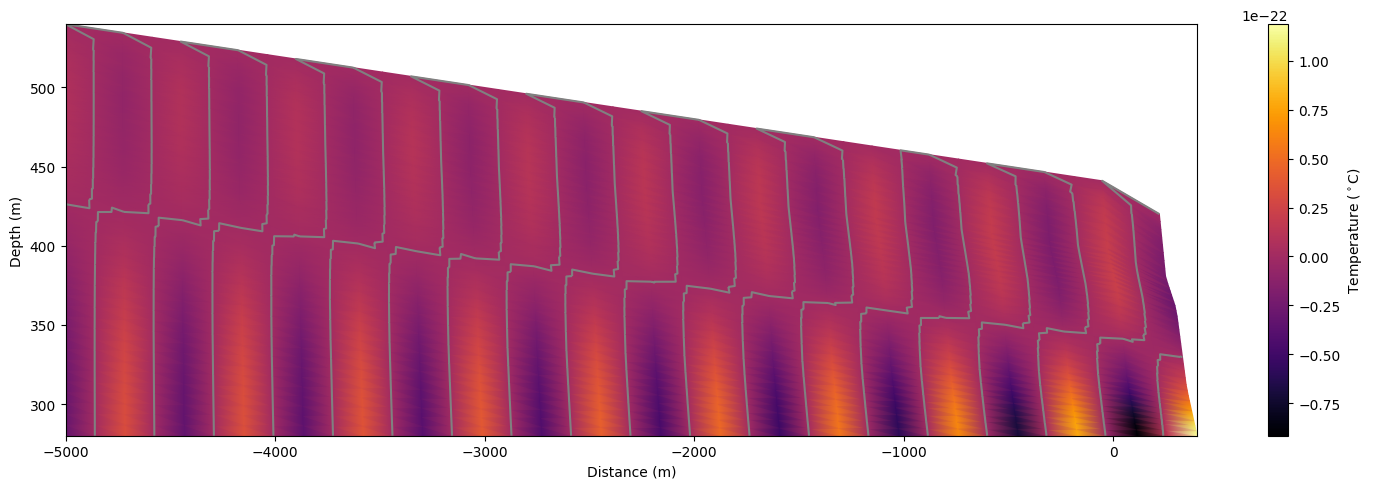

In [89]:
fig, ax = plt.subplots(figsize=[15,5])

ax.set_aspect("auto")
ax.set_xlabel("Distance (m)")
ax.set_ylabel("Depth (m)")
colors = firedrake.tripcolor(T, cmap="inferno", axes=ax)
fig.colorbar(colors, label="Temperature (${}^\circ$C)")
levels = np.linspace(-1, 0, 7)
firedrake.tricontour(T, levels=levels, colors="grey", axes=ax);
plt.tight_layout()
fig.savefig('Test_model_temperature.png')

# Plot a profile extracted from the model

In [22]:
x_loc = 14000
y_values = np.linspace(40, -1150, 100)  # Sample 100 points along the line
x_values = np.array([x_loc]*100)
borehole = []

for y_val in y_values:
    point = (x_loc, y_val)
    borehole.append(T.at(point))

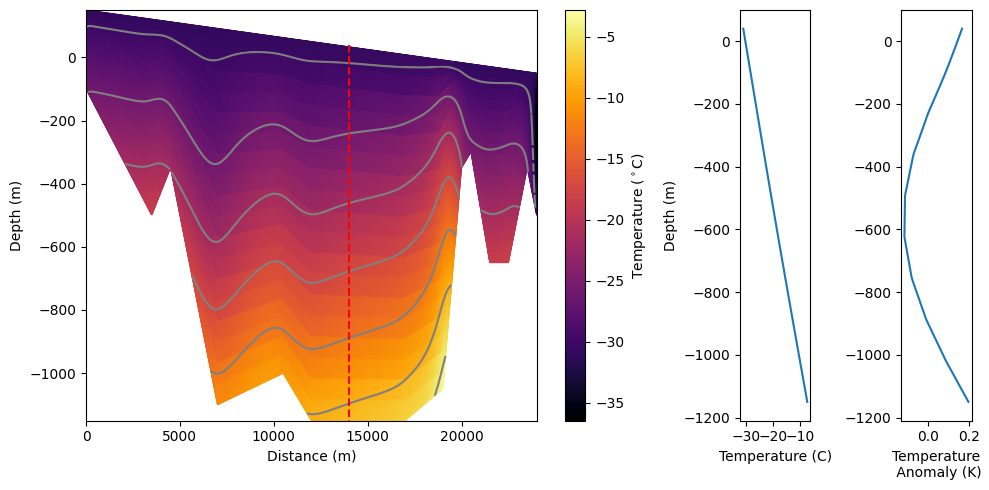

In [23]:

fig, axes = plt.subplots(1,3, figsize=[10,5],gridspec_kw={'width_ratios': [8,1,1]})
axes[0].set_aspect("auto")
axes[0].set_xlabel("Distance (m)")
axes[0].set_ylabel("Depth (m)")
colors = firedrake.tripcolor(T, cmap="inferno", axes=axes[0])
fig.colorbar(colors, label="Temperature (${}^\circ$C)")
levels = np.linspace(-30, 0, 8)
firedrake.tricontour(T, levels=levels, colors="grey", axes=axes[0]);
axes[0].plot(x_values, y_values, c='red',ls='--')


axes[1].plot(borehole,y_values)
axes[2].plot(detrend(borehole), y_values)

axes[1].set_ylabel('Depth (m)')
axes[1].set_xlabel('Temperature (C)')
axes[2].set_xlabel('Temperature\n Anomaly (K)')

plt.tight_layout()

# Detrend the 2D model in the y-direction

In [24]:
# Step 1: Compute integrals for least-squares fit
# Compute the integrals needed to fit the trend u = a * y + b
z_integral = firedrake.assemble(z * firedrake.dx)
T_integral = firedrake.assemble(T * firedrake.dx)
z_squared_integral = firedrake.assemble(z * z * firedrake.dx)
zu_integral = firedrake.assemble(z * T * firedrake.dx)
area = firedrake.assemble(1 * firedrake.dx(mesh))

# Step 2: Calculate the slope (a) and intercept (b) of the trend
a = (zu_integral - (z_integral * T_integral) / area) / (z_squared_integral - (z_integral ** 2) / area)
b = (T_integral - a * z_integral) / area

# Step 3: Define the trend function as a * y + b
trend = firedrake.Function(V).interpolate(a * z + b)

# Step 4: Subtract the trend from the original function
T_detrended = firedrake.Function(V).assign(T - trend)


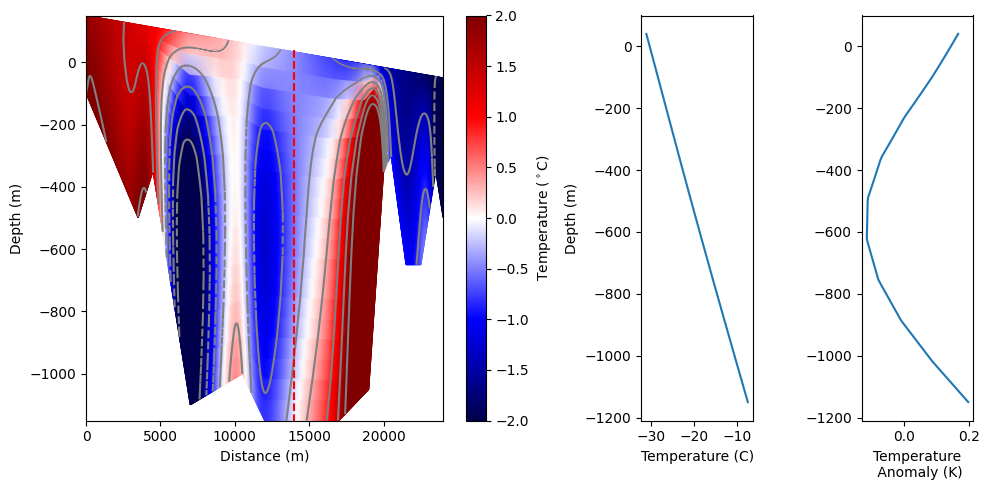

In [60]:

fig, axes = plt.subplots(1,3, figsize=[10,5],gridspec_kw={'width_ratios': [8,2,2]})
axes[0].set_aspect("auto")
axes[0].set_xlabel("Distance (m)")
axes[0].set_ylabel("Depth (m)")
colors = firedrake.tripcolor(T_detrended, cmap="seismic", axes=axes[0], vmin=-2,vmax=2)
fig.colorbar(colors, label="Temperature (${}^\circ$C)")
levels = np.linspace(-2, 2, 8)
firedrake.tricontour(T_detrended, levels=levels, colors="grey", axes=axes[0]);
axes[0].plot(x_values, y_values, c='red',ls='--')


axes[1].plot(borehole,y_values)
axes[2].plot(detrend(borehole), y_values)

axes[1].set_ylabel('Depth (m)')
axes[1].set_xlabel('Temperature (C)')
axes[2].set_xlabel('Temperature\n Anomaly (K)')

plt.tight_layout()

# Surface temperature to model

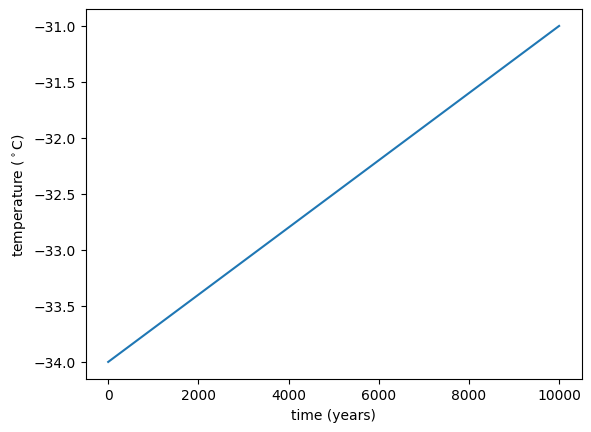

In [35]:
δT = 25.0
θ = 1 * π / 2
year = spy
years = 10000
final_time = years * spy # years modeling * spy

freq = 1 # 1 for annual cycle
num_steps = int(final_time / float(δt))
T_mean_test = -34
mag_warming = 3
# def surface_temperature(t):
#     return T_mean + δT * np.sin(2 * π *freq* t / year + θ) + (t/final_time)*1

def surface_temperature(t):
    return T_mean_test  + (t/final_time)*mag_warming
    
ts = np.linspace(0.0, final_time, num_steps + 1)

surface_temps = surface_temperature(ts)

fig, ax = plt.subplots()
ax.set_xlabel("time (years)")
ax.set_ylabel("temperature (${}^\circ$C)")
ax.plot(ts / spy, surface_temps);

# Run the simulation

In [36]:
import tqdm
final_time = years* spy 
num_steps = int(final_time / float(δt))
Ts = [T.copy(deepcopy=True)]
ys = [y.copy(deepcopy=True)]

for step in tqdm.trange(num_steps):
    t = ts[step]
    T_surface.assign(surface_temperature(t))

    temperature_solver.advance()
    stokes_solver.solve()

    Ts.append(T.copy(deepcopy=True))
    ys.append(y.copy(deepcopy=True))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:55<00:00,  8.68it/s]


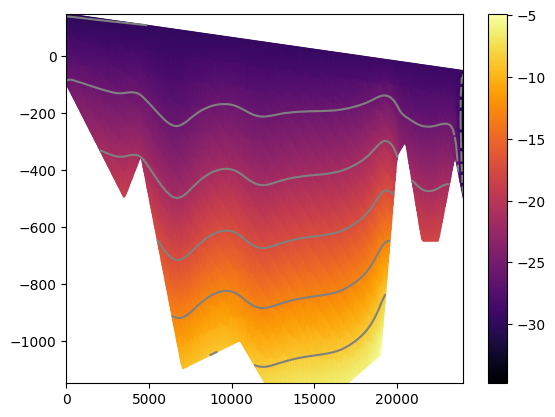

In [37]:
# Check final condition for accuracy
fig, ax = plt.subplots()
temp_field_end = firedrake.tripcolor(Ts[-1],cmap="inferno", axes=ax)
fig.colorbar(colors, label="Temperature (${}^\circ$C)")
levels = np.linspace(-30, 0, 8)
firedrake.tricontour(Ts[-1], levels=levels, colors="grey", axes=ax);
fig.colorbar(temp_field_end)

In [38]:
# Step 1: Compute integrals for least-squares fit
# Compute the integrals needed to fit the trend u = a * y + b
z_integral = firedrake.assemble(z * firedrake.dx)
T_integral = firedrake.assemble(Ts[-1] * firedrake.dx)
z_squared_integral = firedrake.assemble(z * z * firedrake.dx)
zu_integral = firedrake.assemble(z * Ts[-1] * firedrake.dx)
area = firedrake.assemble(1 * firedrake.dx(mesh))

# Step 2: Calculate the slope (a) and intercept (b) of the trend
a = (zu_integral - (z_integral * T_integral) / area) / (z_squared_integral - (z_integral ** 2) / area)
b = (T_integral - a * z_integral) / area

# Step 3: Define the trend function as a * y + b
trend = firedrake.Function(V).interpolate(a * z + b)

# Step 4: Subtract the trend from the original function
T_detrended = firedrake.Function(V).assign(Ts[-1] - trend)

In [39]:
x_loc = 14000
y_values = np.linspace(40, -1150, 100)  # Sample 100 points along the line
x_values = np.array([x_loc]*100)
borehole = []

for y_val in y_values:
    point = (x_loc, y_val)
    borehole.append(Ts[-1].at(point))

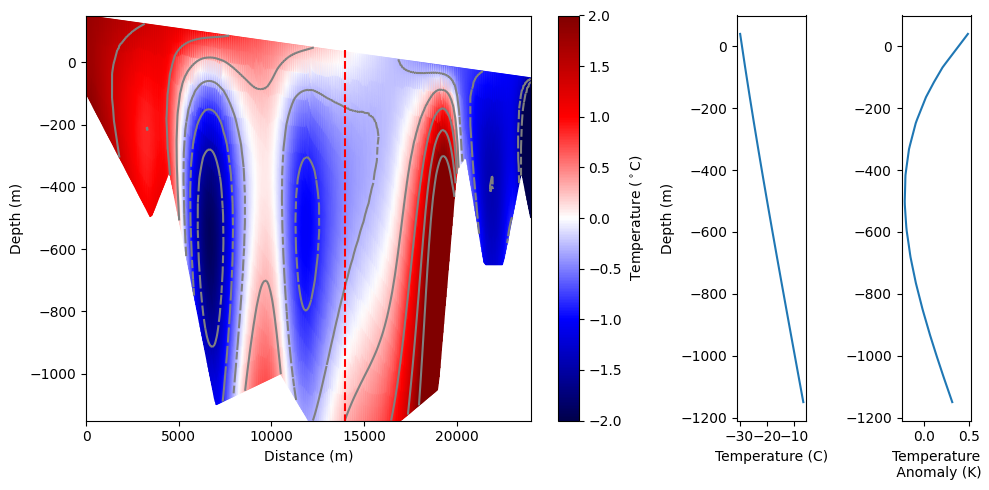

In [40]:

fig, axes = plt.subplots(1,3, figsize=[10,5],gridspec_kw={'width_ratios': [8,1,1]})
axes[0].set_aspect("auto")
axes[0].set_xlabel("Distance (m)")
axes[0].set_ylabel("Depth (m)")
colors = firedrake.tripcolor(T_detrended, cmap="seismic", axes=axes[0], vmin=-2,vmax=2)
fig.colorbar(colors, label="Temperature (${}^\circ$C)")
levels = np.linspace(-2, 2, 8)
firedrake.tricontour(T_detrended, levels=levels, colors="grey", axes=axes[0]);
axes[0].plot(x_values, y_values, c='red',ls='--')


axes[1].plot(borehole,y_values)
axes[2].plot(detrend(borehole), y_values)

axes[1].set_ylabel('Depth (m)')
axes[1].set_xlabel('Temperature (C)')
axes[2].set_xlabel('Temperature\n Anomaly (K)')

plt.tight_layout()

In [41]:

%%capture

def subplots():
    fig, axes = plt.subplots(figsize=[20,5])
    axes.set_aspect("auto")
    axes.get_xaxis().set_visible(True)
    axes.get_yaxis().set_visible(True)
    return fig, axes

fig, axes = subplots()
colors = firedrake.tripcolor(
    Ts[0], num_sample_points=4, vmin=-30, vmax=-10, cmap="inferno", axes=axes
)
# axes.set_xlim([9000,10000])
# axes.set_ylim([-300,10])
fig.colorbar(colors)

In [42]:
from matplotlib.animation import FuncAnimation
fn_plotter = firedrake.FunctionPlotter(mesh, num_sample_points=4)
def animate(T):
    colors.set_array(fn_plotter(T))

animation = FuncAnimation(fig, animate, frames=Ts, interval=1e4/24)

from IPython.display import HTML
HTML(animation.to_html5_video())

In [ ]:
# TODO::

# 1) Put in a borehole on the right hand side and extract the value of temperature
# 2) Change the geometry to something where we actually have data
# 3) Have rheology vary as a function of space,
        # Calculate straain, then calculate the viscosity field and update the calculation with that
        # then recalculate the strain and rheology field and update until not changing very much.

# _______________________________________________________________________________

# Trying a different way

## Maybe dont do this way

In [ ]:
import irksome
from irksome import Dt

δx = mesh.cell_sizes.dat.data_ro[:].min()
umax = y.sub(0).dat.data_ro[:].max()
δt = Constant(spy/12)


F_diffusion = k*inner(grad(T), grad(ϕ)) * dx
F_advection = - ρ * c * T * inner(u, grad(ϕ)) * dx

T_n = firedrake.Function(V)

F = ρ * c * (T-T_n) * ϕ * dx + F_advection + F_diffusion + geothermal_flux


upper_bc = firedrake.DirichletBC(V, T_surface, [4])
bcs = [upper_bc]

method = irksome.BackwardEuler()
temperature_solver = irksome.TimeStepper(F, method, Constant(0.0), δt, T, bcs=bcs)

In [ ]:
δT = 25.0
θ = 1 * π / 2
year = spy
years = 4
final_time = years * spy # years modeling * spy

freq = 1 # 1 for annual cycle
num_steps = int(final_time / float(δt))

def surface_temperature(t):
    return T_surface + δT * np.sin(2 * π *freq* t / year + θ)


ts = np.linspace(0.0, final_time, num_steps + 1)

# surface_temps = surface_temperature(ts)

# fig, ax = plt.subplots()
# ax.set_xlabel("time (years)")
# ax.set_ylabel("temperature (${}^\circ$C)")
# ax.plot(ts / spy, surface_temps);

In [ ]:
F_0 = F_advection + F_diffusion + geothermal_flux
#F_0 = F_diffusion + geothermal_flux

upper_bc_init = firedrake.DirichletBC(V, -31, [4])
bcs_init = [upper_bc_init]
firedrake.solve(F_0 == 0, T, bcs_init)

In [ ]:
fig, ax = plt.subplots()
ax.set_aspect("auto")
ax.set_xlabel("x (m)")
ax.set_ylabel("z (m)")
colors = firedrake.tripcolor(T, cmap="inferno", axes=ax)
fig.colorbar(colors, label="temperature (${}^\circ$C)")
levels = np.linspace(-30, 0, 10)
firedrake.tricontour(T, levels=levels, colors="grey", axes=ax);

In [ ]:
T_n.assign(T)

In [ ]:
import tqdm
final_time = years* spy 
num_steps = int(final_time / float(δt))
Ts = [T.copy(deepcopy=True)]
ys = [y.copy(deepcopy=True)]

for step in tqdm.trange(num_steps):

    T_surface.assign(surface_temperature(step))
    print(surface_temperature(step))
    print(T_surface)
    temperature_solver.advance()
    stokes_solver.solve()
    T_n.assign(T)
    Ts.append(T.copy(deepcopy=True))
    ys.append(y.copy(deepcopy=True))

In [ ]:
# Check final condition for accuracy
fig, ax = plt.subplots()
temp_field_end = firedrake.tripcolor(Ts[-1], axes=ax);
fig.colorbar(temp_field_end)

In [ ]:
%%capture

def subplots():
    fig, axes = plt.subplots(figsize=[10,10])
    axes.set_aspect("equal")
    axes.get_xaxis().set_visible(True)
    axes.get_yaxis().set_visible(True)
    return fig, axes

fig, axes = subplots()
colors = firedrake.tripcolor(
    Ts[0], num_sample_points=4, vmin=-30, vmax=0, cmap="inferno", axes=axes
)
fig.colorbar(colors)

In [ ]:
from matplotlib.animation import FuncAnimation
fn_plotter = firedrake.FunctionPlotter(mesh, num_sample_points=4)
def animate(T):
    colors.set_array(fn_plotter(T))

animation = FuncAnimation(fig, animate, frames=Ts, interval=1e3/24)

from IPython.display import HTML
HTML(animation.to_html5_video())